In [1]:
import pandas as pd
df = pd.read_csv("..//static//csv//car_price_prediction.csv", sep=",")


In [2]:
df.head()

ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1     Tiptronic          4x4  04-May        Left wheel   Black        8  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4

## Бизнес-цели
- **Задача регрессии**: Построить модель для предсказания цены автомобиля (`Price`) на основе его характеристик.
- **Задача классификации**: Определить категорию автомобиля (`Category`) по характеристикам.

Ввиду того что я первый раз обучаю модель прогнозируемое качество предсказания - не выше 50 %

In [3]:
df.dtypes

ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

# небольшая обработка данных

In [4]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Price'] >= Q1 - 1.5 * IQR) & (df['Price'] <= Q3 + 1.5 * IQR)]

In [5]:
df['Levy']=pd.to_numeric(df['Levy'],errors='coerce')

In [6]:
df['Mileage'] = df['Mileage'].str.replace(' km', '').str.replace(',', '')
df['Mileage'] = df['Mileage'].astype(int)

In [7]:
import re

df['Engine volume'] = df['Engine volume'].apply(lambda x: float(re.match(r'\d+(\.\d+)?', x).group()) if isinstance(x, str) else x)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
# Разделим данные на признаки и целевые переменные
X = df.drop(columns=['Price','ID'])  # Признаки
y = df['Price']  # Целевая переменная для регрессии

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# наполняем пайплайн обработчиками

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Определение числовых и категориальных столбцов
numeric_features = ['Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']
categorical_features = ['Manufacturer', 'Model', 'Category', 'Fuel type', 
                        'Gear box type', 'Drive wheels', 'Doors', 
                        'Wheel', 'Color']

# Обработка числовых данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропусков медианой
    ('scaler', StandardScaler())                   # Нормализация данных
])

# Обработка категориальных данных
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Преобразование в One-Hot Encoding
])

# Комбинированный трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),   # Применяем числовую обработку
        ('cat', categorical_transformer, categorical_features)  # Применяем категориальную обработку
    ]
)


In [12]:
X_transformed = preprocessor.fit_transform(X)

print(f"Transformed feature shape: {X_transformed.shape}")

Transformed feature shape: (17869, 1610)


# посмотрим результат пайплайна

In [13]:
# Получим имена категориальных признаков после OneHotEncoder
categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Объединим их с именами числовых признаков
feature_names = list(numeric_features) + list(categorical_feature_names)

# Создадим DataFrame для преобразованных данных
X_transformed_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed, columns=feature_names)

# Выведем пример 5 строк
X_transformed_df

Prod. year  Engine volume   Mileage  Cylinders   Airbags  \
0       -0.117071       1.427610 -0.029000   1.256101  1.255022   
1        0.060861       0.844069 -0.028881   1.256101  0.330220   
2       -0.828800      -1.139970 -0.028722  -0.470989 -1.056983   
3        0.060861       0.260528 -0.029340  -0.470989 -1.519384   
4        0.594657      -1.139970 -0.030874  -0.470989 -0.594582   
...           ...            ...       ...        ...       ...   
17864   -2.074326      -0.323013 -0.026730  -0.470989 -0.363382   
17865    0.060861       0.143820 -0.029486  -0.470989  0.330220   
17866   -0.117071      -0.323013 -0.030387  -0.470989 -0.594582   
17867   -0.650868      -0.323013 -0.031684  -0.470989 -0.594582   
17868    0.238793       0.143820 -0.028982  -0.470989  1.255022   

       Manufacturer_ACURA  Manufacturer_ALFA ROMEO  Manufacturer_AUDI  \
0                     0.0                      0.0                0.0   
1                     0.0                      0.0                0.0   
2                     0.0                      0.0                0.0   
3                     0.0                      0.0                0.0   
4                     0.0                      0.0                0.0   
...                   ...                      ...                ...   
17864                 0.0                      0.0                0.0   
17865                 0.0                      0.0                0.0   
17866                 0.0                      0.0                0.0   
17867                 0.0                      0.0                0.0   
17868                 0.0                      0.0                0.0   

       Manufacturer_BMW  Manufacturer_BUICK  ...  Color_Green  Color_Grey  \
0                   0.0                 0.0  ...          0.0         0.0   
1                   0.0                 0.0  ...          0.0         0.0   
2                   0.0                 0.0  ...          0.0         0.0   
3                   0.0                 0.0  ...          0.0         0.0   
4                   0.0                 0.0  ...          0.0         0.0   
...                 ...                 ...  ...          ...         ...   
17864               0.0                 0.0  ...          0.0         0.0   
17865               0.0                 0.0  ...          0.0         0.0   
17866               0.0                 0.0  ...          0.0         1.0   
17867               0.0                 0.0  ...          0.0         0.0   
17868               0.0                 0.0  ...          0.0         0.0   

       Color_Orange  Color_Pink  Color_Purple  Color_Red  Color_Silver  \
0               0.0         0.0           0.0        0.0           1.0   
1               0.0         0.0           0.0        0.0           0.0   
2               0.0         0.0           0.0        0.0           0.0   
3               0.0         0.0           0.0        0.0           0.0   
4               0.0         0.0           0.0        0.0           1.0   
...             ...         ...           ...        ...           ...   
17864           0.0         0.0           0.0        0.0           1.0   
17865           0.0         0.0           0.0        1.0           0.0   
17866           0.0         0.0           0.0        0.0           0.0   
17867           0.0         0.0           0.0        0.0           0.0   
17868           0.0         0.0           0.0        0.0           0.0   

       Color_Sky blue  Color_White  Color_Yellow  
0                 0.0          0.0           0.0  
1                 0.0          0.0           0.0  
2                 0.0          0.0           0.0  
3                 0.0          1.0           0.0  
4                 0.0          0.0           0.0  
...               ...          ...           ...  
17864             0.0          0.0           0.0  
17865             0.0          0.0           0.0  
17866             0.0          0.0           0.0  
1

# обучим 3 разные модели с применением RandomizedSearchCV(для подора гиперпараметров)

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

random_state = 42

# Модели и параметры
models_regression = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=random_state),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=random_state)
}

param_grids_regression = {
    "LinearRegression": {},
    "RandomForestRegressor": {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 10]
    }
}

# Результаты
results_regression = {}

# Перебор моделей
for name, model in models_regression.items():
    print(f"Training {name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    param_grid = param_grids_regression[name]
    grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Лучшая модель
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Сохранение результатов
    results_regression[name] = {
        "Best Params": grid_search.best_params_,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

# Печать результатов
for name, metrics in results_regression.items():
    print(f"\nModel: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

Training LinearRegression...


d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training RandomForestRegressor...


d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training GradientBoostingRegressor...


d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Model: LinearRegression
Best Params: {}
MAE: 6722.0902357642335
RMSE: 8991.273616765677
R2: 0.3722951567248176

Model: RandomForestRegressor
Best Params: {'model__n_estimators': 200, 'model__max_depth': None}
MAE: 3568.360497561258
RMSE: 6055.406570308487
R2: 0.7152920023310496

Model: GradientBoostingRegressor
Best Params: {'model__n_estimators': 200, 'model__max_depth': 10, 'model__learning_rate': 0.2}
MAE: 3933.35109066405
RMSE: 6171.208466996527
R2: 0.7042985281049783


In [15]:
# Импортируем pandas для работы с таблицами
import pandas as pd

# Формируем таблицу метрик
reg_metrics = pd.DataFrame.from_dict(results_regression, orient="index")[
    ["MAE", "RMSE", "R2"]
]

# Визуализация результатов с помощью стилизации
styled_metrics = (
    reg_metrics.sort_values(by="RMSE")
    .style.background_gradient(cmap="viridis", low=1, high=0.3, subset=["RMSE", "MAE"])
    .background_gradient(cmap="plasma", low=0.3, high=1, subset=["R2"])
)

styled_metrics

# невероятно
Модель может что-то даже предсказать, с погрешностью в 3к$ конечно и ошибкой 70% но всё же. Я думал и 50% не будет.
Возможно если сузить сильнее входные данные, потому что выбросы очень большие, результат будет лучше. Линейная регрессия кстати вообще не справилась с данными а вот 2 другие ещё более менее

# приступим к задаче классификации

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X = df.drop(columns=['Leather interior','ID'])  # Признаки
# Целевая переменная для классификации
y_class = df['Leather interior'].map({'Yes': 1, 'No': 0})  # Преобразуем в 0/1

# Разделение данных
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Модели и параметры
models_classification = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

param_grids_classification = {
    "LogisticRegression": {
        'model__C': [0.1, 1, 10]
    },
    "RandomForestClassifier": {
        "model__n_estimators": [10, 20, 30, 40, 50, 100, 150, 200, 250, 500],
        "model__max_features": ["sqrt", "log2", 2],
        "model__max_depth": [2, 3, 4, 5, 6, 7, 8, 9 ,10, 20],
        "model__criterion": ["gini", "entropy", "log_loss"],
    },
    "KNN": {
        'model__n_neighbors': [3, 5, 7, 9, 11],
        'model__weights': ['uniform', 'distance']
    }
}

# Результаты
results_classification = {}

# Перебор моделей
for name, model in models_classification.items():
    print(f"Training {name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    param_grid = param_grids_classification[name]
    grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_clf, y_train_clf)

    # Лучшая модель
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_clf)

    # Метрики
    acc = accuracy_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred)

    # Вычисление матрицы ошибок
    c_matrix = confusion_matrix(y_test_clf, y_pred)

    # Сохранение результатов
    results_classification[name] = {
        "Best Params": grid_search.best_params_,
        "Accuracy": acc,
        "F1 Score": f1,
        "Confusion_matrix": c_matrix
    }

# Печать результатов
for name, metrics in results_classification.items():
    print(f"\nModel: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

Training LogisticRegression...


d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training RandomForestClassifier...


d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training KNN...

Model: LogisticRegression
Best Params: {'model__C': 10}
Accuracy: 0.8612199216564074
F1 Score: 0.9032383925087788
Confusion_matrix: [[ 763  303]
 [ 193 2315]]

Model: RandomForestClassifier
Best Params: {'model__n_estimators': 500, 'model__max_features': 'log2', 'model__max_depth': 20, 'model__criterion': 'gini'}
Accuracy: 0.802182428651371
F1 Score: 0.874800779174783
Confusion_matrix: [[ 397  669]
 [  38 2470]]

Model: KNN
Best Params: {'model__weights': 'uniform', 'model__n_neighbors': 5}
Accuracy: 0.8718522663682149
F1 Score: 0.9082532051282052
Confusion_matrix: [[ 849  217]
 [ 241 2267]]


# отресуем красивые квадратики


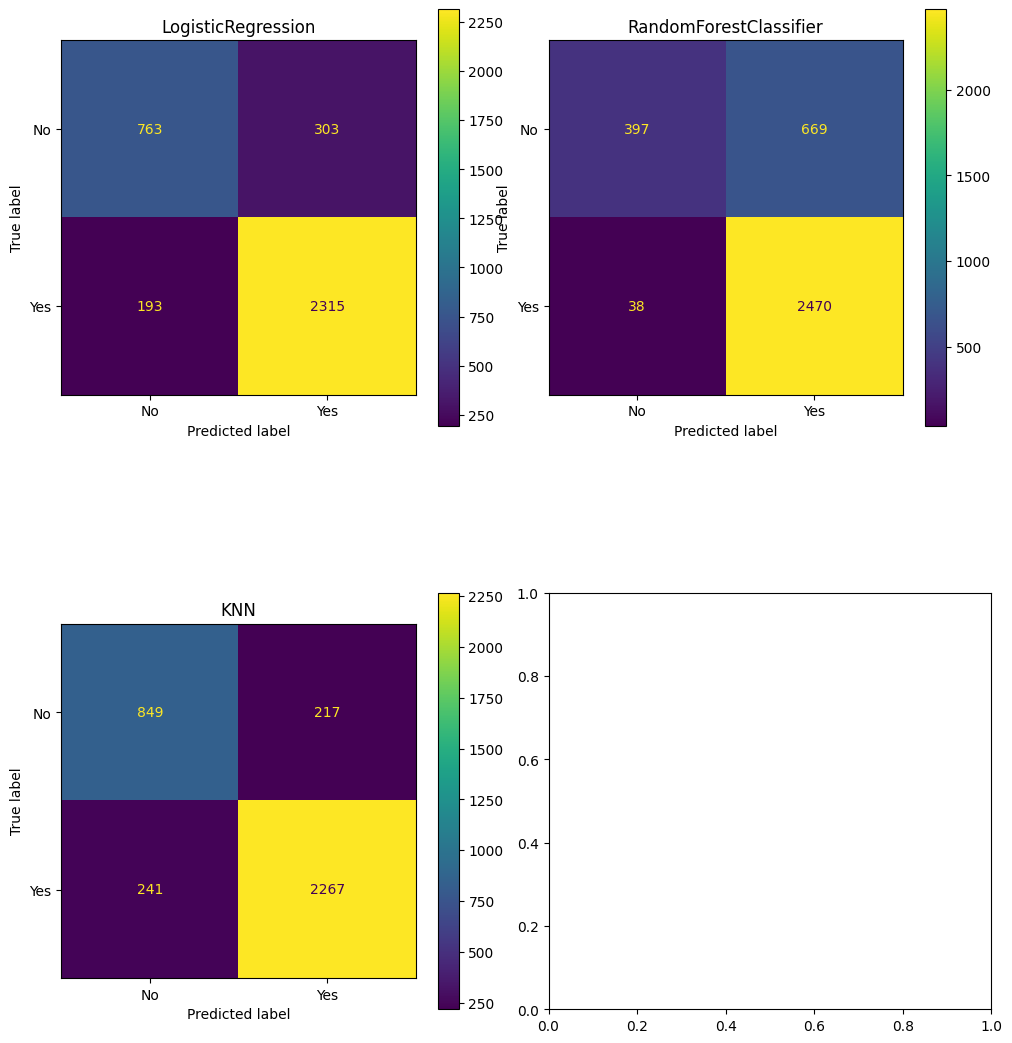

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay


num_models = len(results_classification)
num_rows = (num_models // 2) + (num_models % 2)  # Количество строк для подграфиков
_, ax = plt.subplots(num_rows, 2, figsize=(12, 10), sharex=False, sharey=False)

for index, (name, metrics) in enumerate(results_classification.items()):
    c_matrix = metrics["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["No", "Yes"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(name)

# Корректировка расположения графиков
plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

In [18]:
import pandas as pd

# Формируем таблицу метрик классификации
clf_metrics = pd.DataFrame.from_dict(results_classification, orient="index")[["Accuracy", "F1 Score"]]

# Визуализация результатов с помощью стилизации
styled_metrics_clf = (
    clf_metrics.sort_values(by="F1 Score", ascending=False)  # Сортировка по F1 Score
    .style.background_gradient(cmap="viridis", low=0, high=1, subset=["F1 Score", "Accuracy"])  # Стилизация столбцов
    .background_gradient(cmap="plasma", low=0.3, high=1, subset=["Accuracy"])
)

styled_metrics_clf

В итоге KNN и LogisticRegression выдали точность в 90% что я считаю весьма неплохо. RandomForestClassifier близко, но не так хорошо